# Context

<div class="alert alert-block alert-success"><b>
    
We develop a technology that allows a viewer watching a video online to download the video data either from the broadcaster's Content Delivery Network ('CDN') or from a Peer to Peer Network, using other viewers on the same stream as sources.

During their session, each viewer sends payloads **every two minutes**, containing some metrics collected by our P2P client. The dataset attached to this file (**dstest.zip**) is a sample of those payloads. Each row is a payload sent by a viewer, and has the following columns:

* **company** : The name of the company providing the stream being watched by the user that sent the payload
* **live** : A string indicating if the video being watched is a live stream or a VOD stream
* **content** : The name of the content being watched by the viewer sending the payload
* **p2p** : The volume of data (in bytes) **downloaded through the P2P network** from other viewers during the payload timespan (2 minutes)
* **cdn** : The volume of data (in bytes) **downloaded the CDN** during the payload timespan (2 minutes)
* **upload** : The volume of data (in bytes) **uploaded to other viewers** on the P2P network during the payload timespan (2 minutes)
* **peers_count** : Average number of peers connected to the users during the payload timespan
* **timestamp** : Unix timestamp (UTC) of the moment the payload was sent
* **sessionDuration** : **Total time** elapsed since the beginning of the video session (in milliseconds)
* **playbackErrorCount** : Number of playback errors that occurred during the payload timespan
* **totalPlaybackErrorCount** : Number of playback errors that have occurred since the beginning of the viewer's session

</b></div>

# Packages

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
# pd.set_option('display.width', 1000)

In [2]:
data = pd.read_csv('dataMining/dstest.csv')

df = data.copy()
# data shape
data.shape

(385165, 13)

### **Question 1**
<div class="alert alert-block alert-success"><b>
    
To evaluate the perfomance I propose to use $$\frac{p2p}{p2p + cdn}$$

This measures the proportion of data acquired through the p2p network. There are severl reasons for this choice.

First, we might want to use *upload* for the performance measure but this would mean that we count the data exchange twice if we take the average performance for a company. Indeed, the *upload* measure has to appear in the *p2p* measure of other payloads. Of course, *upload* like *peers_count* give interesting information about the p2p network but this is not a direct observation of the performance.

Another advantage of this measure is that it's bounded to [0,1]. With 0% performance everything is handled by the cdn, which is the worst case scenario. With 100% performance everything is handled by the p2p network, which is the best case scenario. 

Finally, even though the playback errors are an important measure of performance it shouldn't be used here. First because we can't know if the errors are caused by the "solution" or by errors on the client or cdn side. And use the  number of errors in this performance measure might make it more complex to derive conclusions from it. It's better to keep it simple.
    
</b></div>

In [3]:
data.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235


In [4]:
data.mediaEngine.unique()

array(['ME1', 'ME2'], dtype=object)

In [5]:
data.live.unique()

array(['VOD', 'Live'], dtype=object)

In [6]:
data.company.unique()

array(['Streamroot TV', 'Flash Infos', 'Sports News'], dtype=object)

In [7]:
data.content.unique()

array(['content-09235', 'content-17013', 'content-08963', ...,
       'content-04063', 'content-07336', 'content-15027'], dtype=object)

- **response**

In [8]:
data['performance'] = (data['p2p'] / (data['p2p'] + data['cdn']))**2

In [9]:
data.groupby('company')['company','performance'].mean()['performance']

company
Flash Infos      0.334117
Sports News      0.199073
Streamroot TV    0.413680
Name: performance, dtype: float64

### **Question 2**


#### 2.1:

<div class="alert alert-block alert-success"><b>
    
*sessionDuration* should be 2min (120000ms).
</b></div>

#### 2.2 & 2.3 :
    


In [10]:
data['isFirstPayload'] = data['sessionDuration'] == 120000.0
data[data['isFirstPayload']].groupby('company').size()

company
Flash Infos        805
Sports News        115
Streamroot TV    19914
dtype: int64

### **Question 3**

#### 3.1
<div class="alert alert-block alert-success"><b>


| Payload | playbackErrorCount | totalPlaybackErrorCount |
|---------|--------------------|-------------------------|
| 1       | 0                  | 0                       |
| 2       | 1                  | 1                       |
| 3       | 0                  | 1                       |
| 4       | 1                  | 2                       |
| 5       | 0                  | 2                       |

</b></div>

#### 3.2
<div class="alert alert-block alert-success"><b>
    
*playbackErrorCount* is equal to *totalPlaybackErrorCount* just once per session. Which mean that we only need to count the number of payloads where these values are equal and greater than 0.

There are **9** distinct viewers that had at least 1 playback error during their session.

</b></div>

In [11]:
len(data[(data['playbackErrorCount'] == data['totalPlaybackErrorCount']) & data['playbackErrorCount'] > 0].index)

9

### **Question 4**
#### 4.1


In [12]:
data['readableDate'] =  pd.to_datetime(data['timestamp'], unit='ms').dt.round('2min')

#### 4.2

In [13]:
concurrency = data[data['content'] == 'content-05335'].groupby('readableDate')['performance'].agg(['count'])

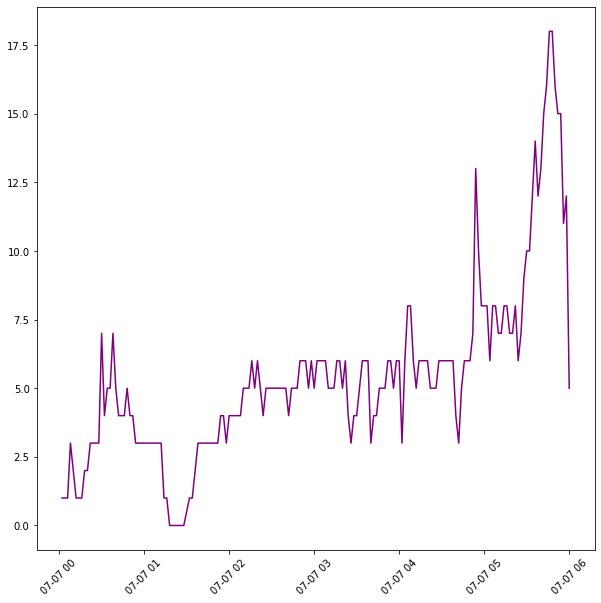

In [14]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(concurrency['count'].index.values,
        concurrency['count'],
        color='purple')

# Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()